In [ ]:
import os

import yaml

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import galcheat
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

from maddeb.dataset_generator import batched_CATSIMDataset
from maddeb.FlowVAEnet import FlowVAEnet
from maddeb.utils import get_data_dir_path, get_maddeb_config_path

%matplotlib inline

In [ ]:
with open(get_maddeb_config_path()) as f:
    maddeb_config = yaml.safe_load(f)

In [ ]:
survey = galcheat.get_survey(maddeb_config["survey_name"])

In [ ]:
linear_norm_coeff = 10000
batch_size = 50

## Load images

In [ ]:
# List of data samples
# Define the generators
ds_isolated_train, ds_isolated_val = batched_CATSIMDataset(
    tf_dataset_dir=os.path.join(
        maddeb_config["TF_DATASET_PATH"][maddeb_config["survey_name"]],
        "isolated_tfDataset",
    ),
    linear_norm_coeff=linear_norm_coeff,
    batch_size=batch_size,
    x_col_name="blended_gal_stamps",
    y_col_name="isolated_gal_stamps",
)
ds_isolated_val = ds_isolated_val.as_numpy_iterator()
ds_isolated_train = ds_isolated_train.as_numpy_iterator()

You use TensorFlow DType <dtype: 'float32'> in tfds.features This will soon be deprecated in favor of NumPy DTypes. In the meantime it was converted to float32.
Load dataset info from /sps/lsst/users/bbiswas/simulations/LSST/isolated_tfDataset/catsim_dataset/1.0.0
Reusing dataset catsim_dataset (/sps/lsst/users/bbiswas/simulations/LSST/isolated_tfDataset/catsim_dataset/1.0.0)
Constructing tf.data.Dataset catsim_dataset for split None, from /sps/lsst/users/bbiswas/simulations/LSST/isolated_tfDataset/catsim_dataset/1.0.0


In [ ]:
isolated_images = next(ds_isolated_val)

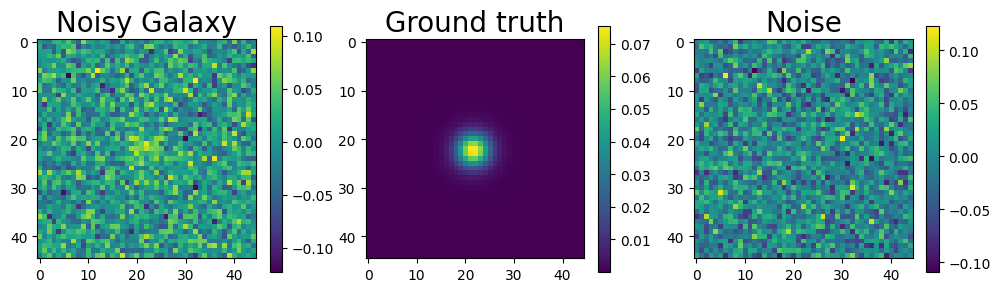

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

image_num = 40

im = axs[0].imshow(isolated_images[0][image_num][:, :, 2])
fig.colorbar(im, ax=axs[0], shrink=0.8)
axs[0].set_title("Noisy Galaxy", fontsize=20)

im = axs[1].imshow(isolated_images[1][image_num][:, :, 2])
fig.colorbar(im, ax=axs[1], shrink=0.8)
axs[1].set_title("Ground truth", fontsize=20)


difference = (
    isolated_images[1][image_num][:, :, 2] - isolated_images[0][image_num][:, :, 2]
)
im = axs[2].imshow(difference)
fig.colorbar(im, ax=axs[2], shrink=0.8)
axs[2].set_title("Noise", fontsize=20)
plt.savefig("isolated_galaxy")

In [ ]:
isolated_images[0][image_num].shape

(45, 45, 6)

## Load trained models

In [ ]:
data_dir = get_data_dir_path()

tf.get_logger().setLevel("ERROR")
latent_dim = 16
num_nf_layers = 6
kl_weight = 1

model_path = os.path.join(data_dir, maddeb_config["survey_name"] + "0.01_b")

flow_net = FlowVAEnet(latent_dim=latent_dim, num_nf_layers=num_nf_layers, survey=survey)

flow_net.load_flow_weights(weights_path=os.path.join(model_path, "flow/val_loss"))
flow_net.load_vae_weights(weights_path=os.path.join(model_path, "vae/val_loss"))


flow_net.vae_model.trainable = False
flow_net.flow_model.trainable = False

# print(flow_net.vae_model.summary())
# print(flow_net.flow_model.summary())

# Section 1: Test the VAE


### Section 1.1 reconstructions.
If the VAE is able to correctly reconstruct images, we can conclude that the decoder can be used as a generative model

In [ ]:
tf.get_logger().setLevel("ERROR")
isolated_images = next(ds_isolated_val)
model_vae_output_isolated = flow_net.vae_model(isolated_images[0])
# model_vae_output_isolated = model_vae_output_isolated

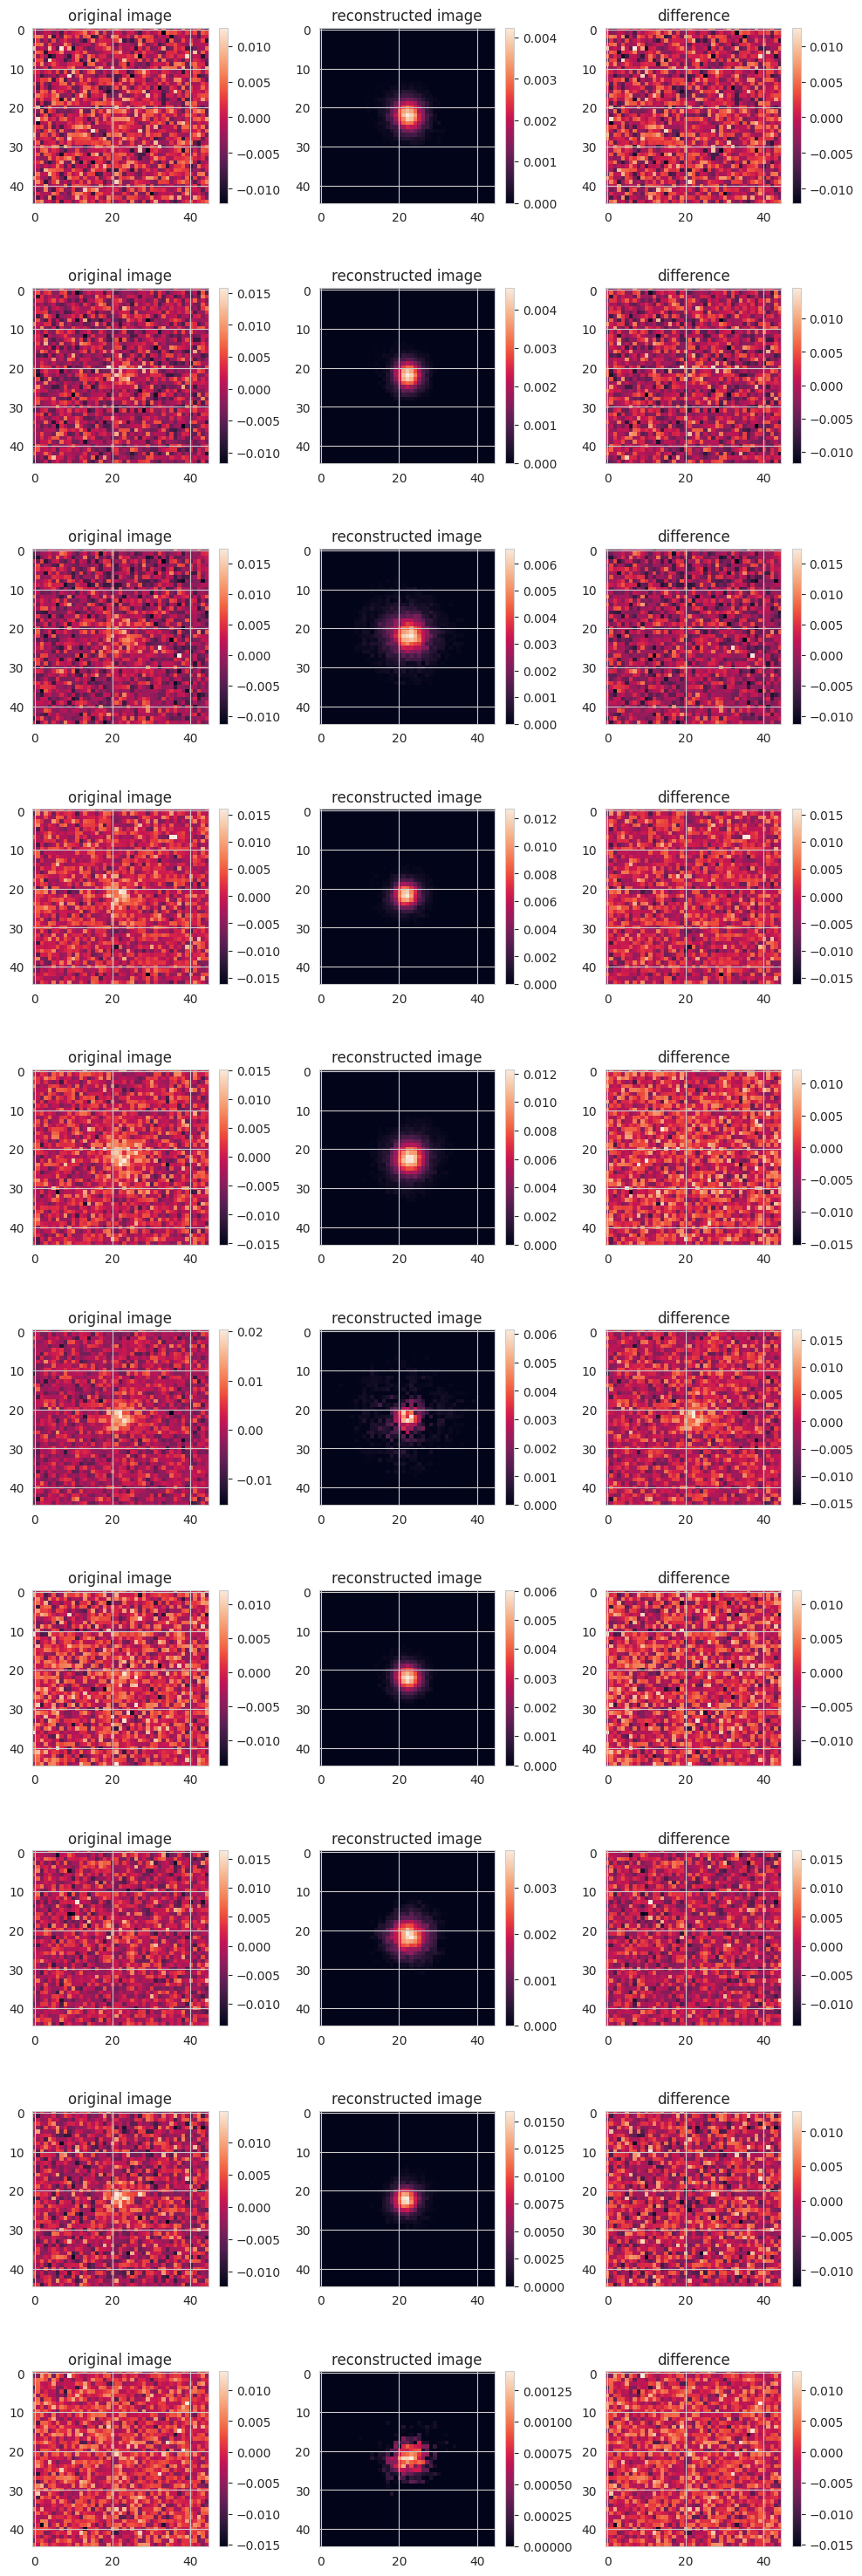

In [ ]:
# sns.set_theme(style={"axes.grid": False,
#                      'axes.labelcolor': 'white',
#                      'figure.facecolor': '.15',
#                      'xtick.color': 'white',
#                      'ytick.color': 'white',
#                      'text.color': 'white',
#                      'image.cmap': 'viridis',})

sns.set_style("whitegrid")

fig, axs = plt.subplots(10, 3, figsize=(10, 30))

for i in range(10):

    image_num = i + 30
    band_num = 0
    im = axs[i, 0].imshow(isolated_images[0][image_num][:, :, band_num])
    fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    axs[i, 0].set_title("original image")

    im = axs[i, 1].imshow(model_vae_output_isolated.numpy()[image_num][:, :, band_num])
    fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    axs[i, 1].set_title("reconstructed image")

    difference = (
        isolated_images[0][image_num][:, :, band_num]
        - model_vae_output_isolated.numpy()[image_num][:, :, band_num]
    )
    im = axs[i, 2].imshow(difference)
    fig.colorbar(im, ax=axs[i, 2], shrink=0.8)
    axs[i, 2].set_title("difference")

plt.tight_layout()

Conclusion: The reconstructions of galaxies work fairly well! <br>
So the decoder can be used as a generative model by sampling from the latent space.

In this section we look  the latent space distribution of galaxies as learnt by the VAE

In [ ]:
z = tfp.layers.MultivariateNormalTriL(event_size=latent_dim)(
    flow_net.encoder(isolated_images[0])
)

In [ ]:
latent_vars = []
for i in range(200):
    isolated_images_batch = next(ds_isolated_val)
    # images_isolated_normed = np.transpose(images_isolated_normed, axes=(0, 2, 3, 1))
    z = tfp.layers.MultivariateNormalTriL(event_size=latent_dim)(
        flow_net.encoder(isolated_images_batch[0])
    )

    latent_vars.extend(list(z.sample().numpy()))
latent_vars = np.array(latent_vars)

In [ ]:
print(latent_vars.shape)

(10000, 16)


In [ ]:
latent_vars_list = []
for i in range(latent_dim):
    latent_vars_list.append(latent_vars[:, i])

The plot shows the distribution of the latent space variables as learnt by the VAE. <br>
In the next section we will try to see if we can model this distribution using the Normalizing Flow network. 

(-1.25, 1.25)

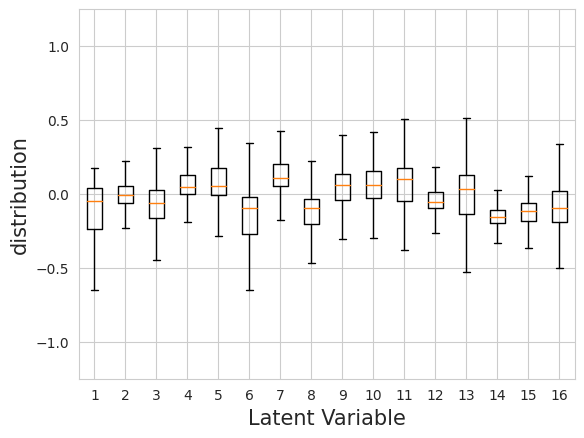

In [ ]:
plt.boxplot(latent_vars_list, showfliers=False)
plt.xlabel("Latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)
plt.ylim([-1.25, 1.25])

# Section 2. Test the flow network

In this section, we will test if the flow network assigns high probability to data it had seen trained on relative to unseen galaxies.

In [ ]:
_, ds_blended_val = batched_CATSIMDataset(
    tf_dataset_dir=os.path.join(
        maddeb_config["TF_DATASET_PATH"][maddeb_config["survey_name"]],
        "blended_tfDataset",
    ),
    batch_size=batch_size,
    x_col_name="blended_gal_stamps",
    y_col_name="isolated_gal_stamps",
    linear_norm_coeff=linear_norm_coeff,
)
ds_blended_val = ds_blended_val.as_numpy_iterator()

Load dataset info from /sps/lsst/users/bbiswas/simulations/LSST/blended_tfDataset/catsim_dataset/1.0.0
Reusing dataset catsim_dataset (/sps/lsst/users/bbiswas/simulations/LSST/blended_tfDataset/catsim_dataset/1.0.0)
Constructing tf.data.Dataset catsim_dataset for split None, from /sps/lsst/users/bbiswas/simulations/LSST/blended_tfDataset/catsim_dataset/1.0.0


In [ ]:
blended_images = next(ds_blended_val)

let's try to see the distribution of latent variables learnt by the normalizing flow:

In [ ]:
sampled_latent_vars = flow_net.td.sample(len(latent_vars_list[0]), seed=13).numpy()
sampled_latent_vars_list = []
for i in range(latent_dim):
    sampled_latent_vars_list.append(sampled_latent_vars[:, i])

In [ ]:
print(len(sampled_latent_vars))

10000


On comparing the sampled latent space distribution with the actual distribution, we see by eye that the flow nework is able to learn the complex distribution in the latent space.

In [ ]:
latent_value = []
latent_var_num = []
latent_type = []

for i in range(latent_dim):
    latent_value.extend(list(latent_vars_list[i]))
    latent_var_num.extend([i] * len(latent_vars_list[i]))
    latent_type.extend(["actual"] * len(latent_vars_list[i]))

    latent_value.extend(list(sampled_latent_vars_list[i]))
    latent_var_num.extend([i] * len(sampled_latent_vars_list[i]))
    latent_type.extend(["learnt"] * len(sampled_latent_vars_list[i]))

df_plot = {
    "latent_value": latent_value,
    "latent_var_num": latent_var_num,
    "latent_type": latent_type,
}

In [ ]:
df_plot = pd.DataFrame(df_plot)

(-1.25, 1.25)

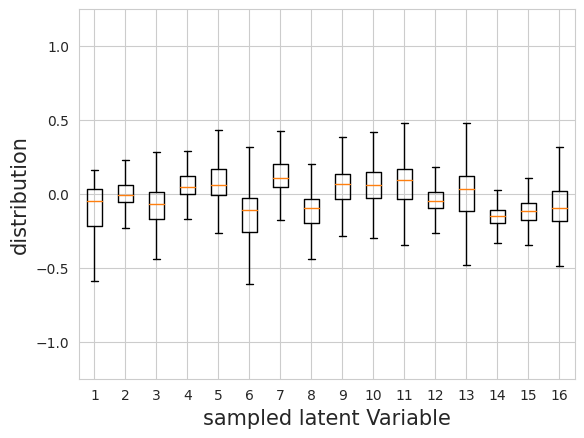

In [ ]:
plt.boxplot(sampled_latent_vars_list, showfliers=False)
plt.xlabel("sampled latent Variable", fontsize=15)
plt.ylabel("distribution", fontsize=15)
plt.ylim([-1.25, 1.25])

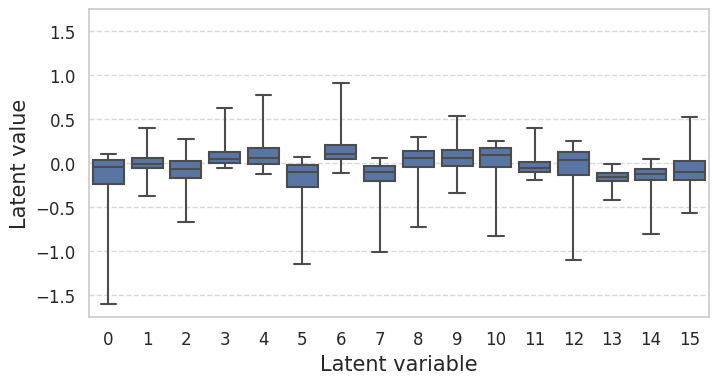

In [ ]:
sns.set(font_scale=1.75)
sns.set_style("whitegrid", {"grid.color": ".85", "grid.linestyle": "--"})
f, ax = plt.subplots(figsize=(8, 4))
ax = sns.boxplot(
    data=df_plot[df_plot["latent_type"] == "actual"],
    x="latent_var_num",
    y="latent_value",
    showfliers=False,
    whis=[5, 95],
    color="b",
)
ax.set_ylim(-1.75, 1.75)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_xlabel("Latent variable", fontsize=15)
ax.set_ylabel("Latent value", fontsize=15)

plt.savefig("results/latent_boxplot")
plt.savefig("results/latent_boxplot.pdf", bbox_inches="tight")

In [ ]:
latent_value = []
latent_var_num = []
latent_type = []

df_sns = {}

for i in range(5):
    df_sns["Variable " + str(i + 1)] = np.concatenate(
        (latent_vars_list[i], sampled_latent_vars_list[i])
    )

df_sns["latent type"] = ["actual"] * len(latent_vars_list[i]) + ["NF modeled"] * len(
    sampled_latent_vars_list[i]
)
df_sns = pd.DataFrame(df_sns)

In [ ]:
# df_sns = df_sns.sample(5000)

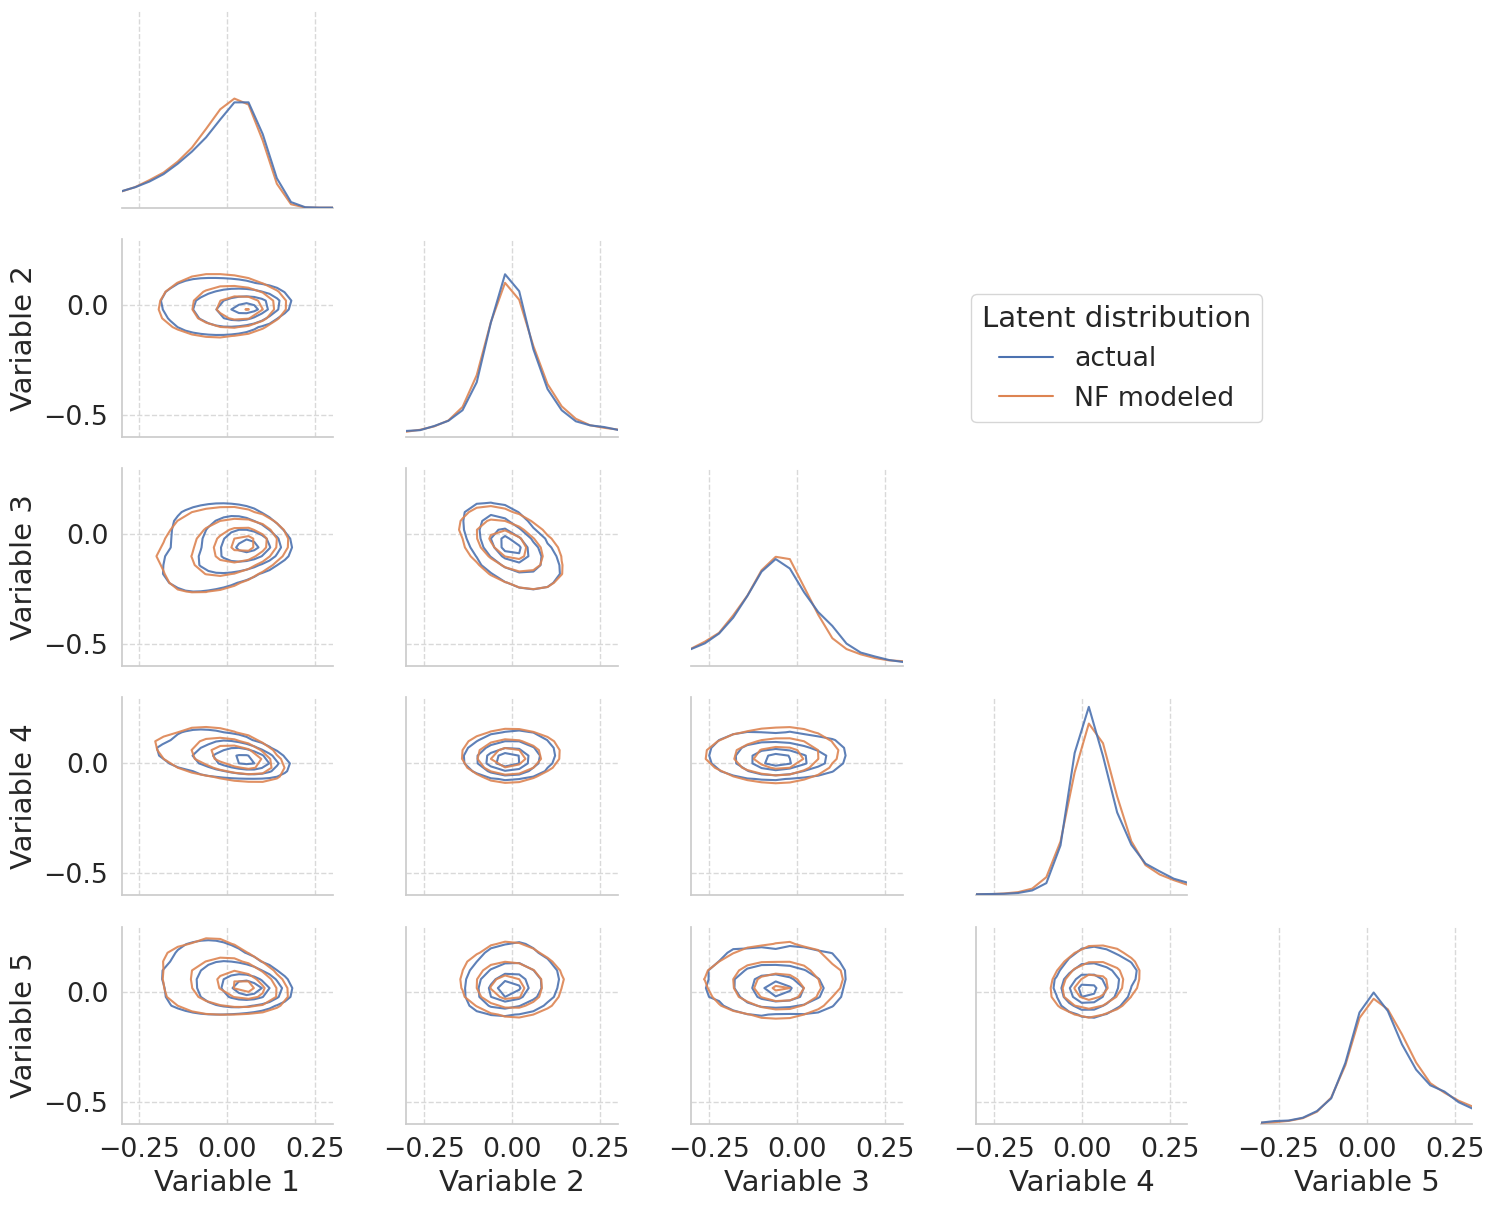

In [ ]:
sns.set_theme(
    font_scale=1.75, style="whitegrid", rc={"grid.color": ".85", "grid.linestyle": "--"}
)
g = sns.PairGrid(df_sns, hue="latent type", corner=True)

g.map_lower(
    sns.kdeplot,
    clip=[-4, 4],
    levels=[0.4, 0.6, 0.8, 0.95],
    gridsize=200,
    common_grid=True,
    bw_adjust=0.1,
    fill=False,
    alpha=0.9,
)
g.map_diag(
    sns.kdeplot,
    clip=[-4, 4],
    gridsize=200,
    common_grid=True,
    common_norm=True,
    bw_adjust=0.1,
    alpha=0.9,
)


for col in range(5):
    g.axes[col, col].set_xlim([-0.3, 0.3])
    g.axes[col, col].set_ylim([-0.6, 0.3])

g.add_legend(title="Latent distribution", loc=[0.65, 0.65], frameon=True)
plt.tight_layout()

plt.savefig("results/latent_distribution_correlation")
plt.savefig("results/latent_distribution_correlation.pdf", bbox_inches="tight")

# Test VAE as deblender

In [ ]:
flow_net.load_encoder_weights(
    weights_path=os.path.join(model_path, "deblender/val_loss")
)

In [ ]:
tf.get_logger().setLevel("ERROR")
deblended_output_isolated = flow_net.vae_model(blended_images[0])

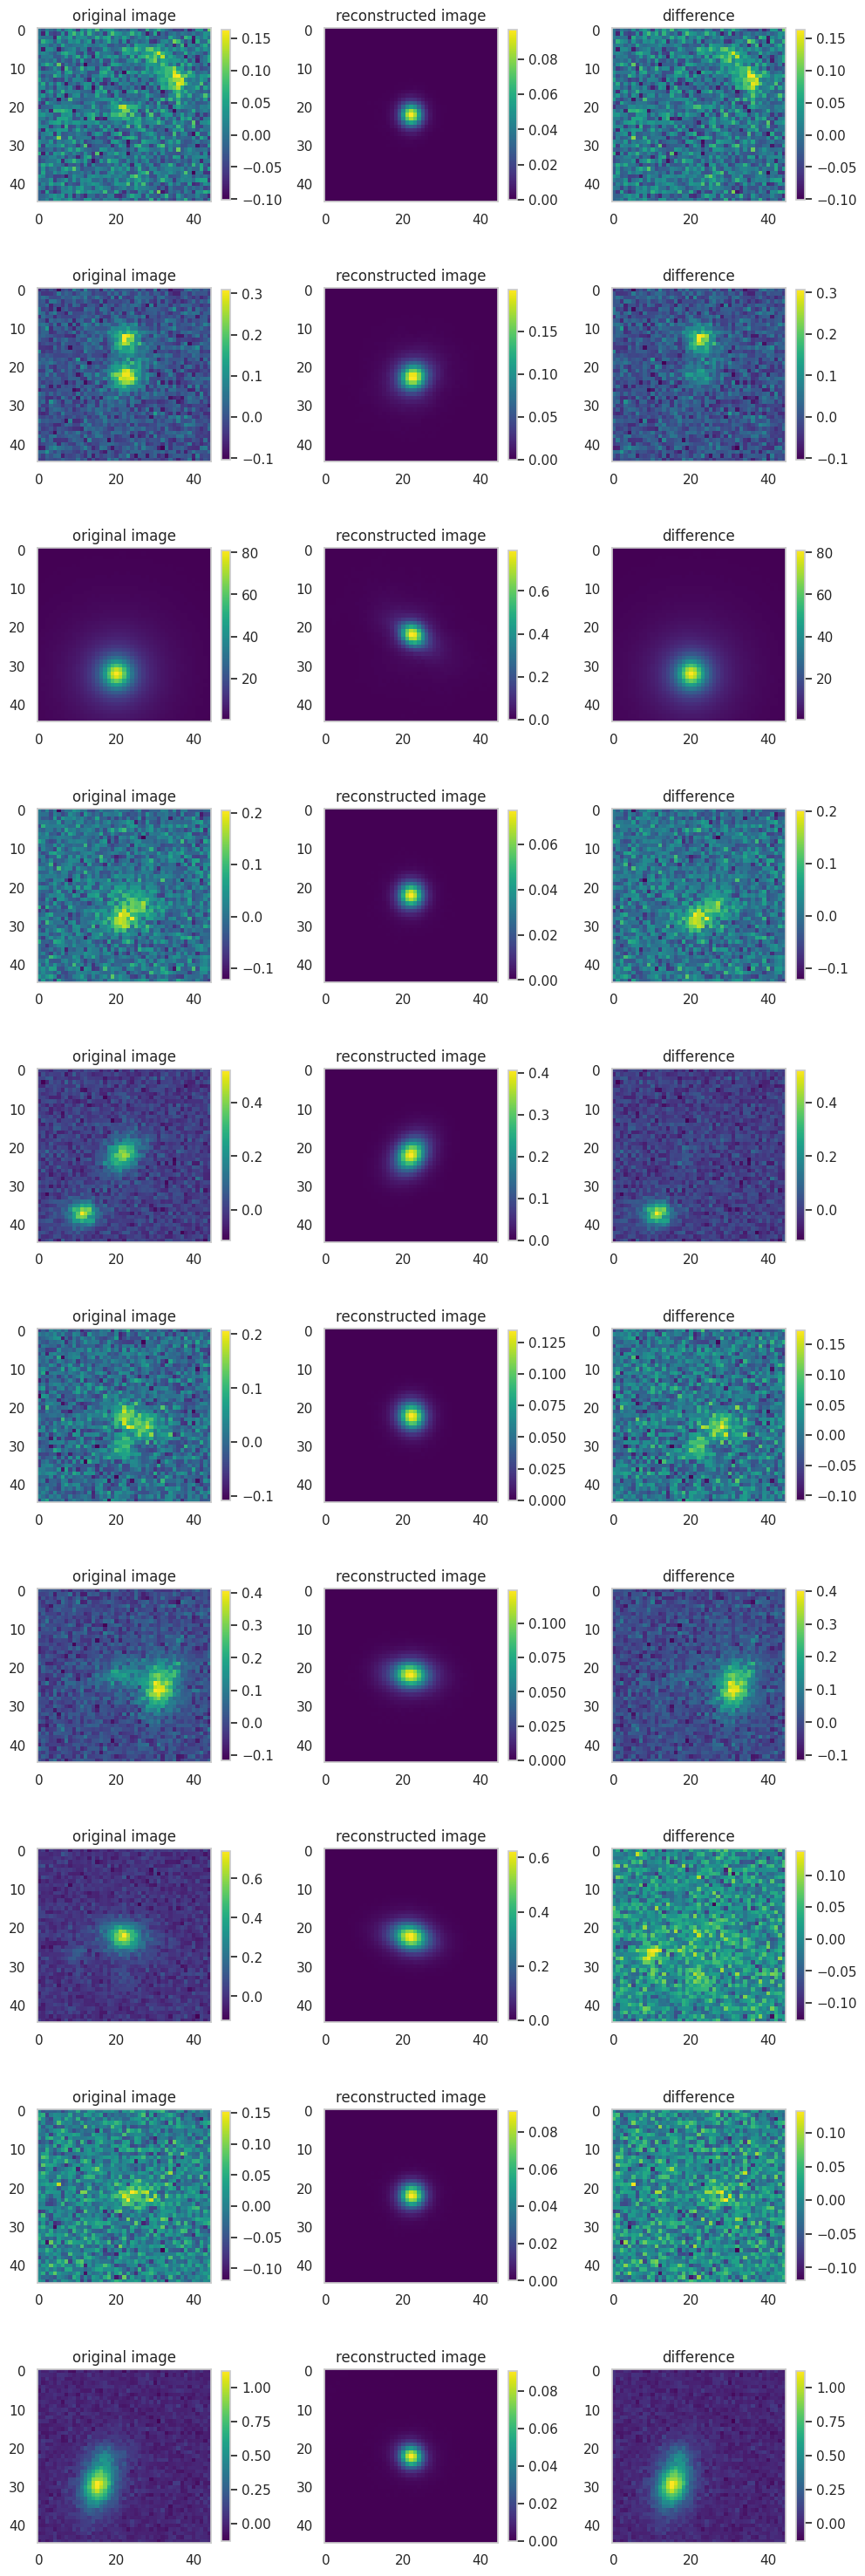

In [ ]:
sns.set_style("whitegrid")
sns.set_theme(
    style={
        "axes.grid": False,
        "image.cmap": "viridis",
    }
)
fig, axs = plt.subplots(10, 3, figsize=(10, 30))

for i in range(10):

    image_num = i + 40
    band_num = 2
    im = axs[i, 0].imshow(blended_images[0][image_num][:, :, band_num])
    fig.colorbar(im, ax=axs[i, 0], shrink=0.8)
    axs[i, 0].set_title("original image")

    im = axs[i, 1].imshow(deblended_output_isolated.numpy()[image_num][:, :, band_num])
    fig.colorbar(im, ax=axs[i, 1], shrink=0.8)
    axs[i, 1].set_title("reconstructed image")

    difference = (
        blended_images[0][image_num][:, :, band_num]
        - deblended_output_isolated.numpy()[image_num][:, :, band_num]
    )
    im = axs[i, 2].imshow(difference)
    fig.colorbar(im, ax=axs[i, 2], shrink=0.8)
    axs[i, 2].set_title("difference")

plt.tight_layout()

##### 